# Implement V subtraction method

### Mar 26, 2021

What we'll do is the perform the noise subtraction in linear space. We will subtrac every single soft-trigger waveform off a single SpiceCore event. This will return a distribution. Since we're technically adding noise, 1$\sigma$ of the distribution corresponds to the mean of the noise rms, so signal+noise. 2$\sigma$ correspond to the 

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")
import time

## Aux. functions

In [3]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

## Expected polarization 

In [4]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    polFinal = newOmegaPol-np.degrees(rotAngle)
    return polFinal, np.degrees(rt.solutions[0].theta0), 180-np.degrees(np.arccos(path.received_direction[2]))

# Soft triggers distribution

In [5]:
wf = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_Reconstruction/DPulseWforms_run012559_allDepths.pkl")
softWf = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_Reconstruction/SoftTrigWforms_run012559.pkl")

### Add interpolated depth to df

In [6]:
depth_1224 = pd.read_csv("./plots/SpiceCorePolReco/A2_1224Depth.txt")
time = pd.to_datetime(depth_1224.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=24, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [7]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1224.depth,bounds_error=False, fill_value=0.)
wf = wf.loc[(wf.unixTime>min(wf.unixTime)) & (wf.unixTime<2.15*1E4+1.5456*1E9)]
softWf = softWf.loc[(softWf.unixTime>min(wf.unixTime)) & (softWf.unixTime<2.15*1E4+1.5456*1E9)]

interp_depth = f(wf.unixTime)
interp_depthSoft = f(softWf.unixTime)

wf["interp_depth"] = interp_depth
softWf["interp_depth"] = interp_depthSoft

In [8]:
def calculatePower(t, v):
    dT = t[1]-t[0]
    power = np.sum(v**2)*dT
    return power

In [9]:
# wf.to_pickle("./data/SpiceCoreforSeckel_run012559.pkl")
# softWf.to_pickle("./data/SoftTrigsforSeckel_run012559.pkl")

In [10]:
wf.columns

Index(['evNum', 'ch0Wf', 'ch1Wf', 'ch2Wf', 'ch3Wf', 'ch4Wf', 'ch5Wf', 'ch6Wf',
       'ch7Wf', 'ch8Wf', 'ch9Wf', 'ch10Wf', 'ch11Wf', 'ch12Wf', 'ch13Wf',
       'ch14Wf', 'ch15Wf', 'times', 'theta_reco', 'phi_reco', 'unixTime',
       'interp_depth'],
      dtype='object')

In [11]:
wf = wf.drop(columns=['evNum','theta_reco', 'phi_reco', 'unixTime'])


In [12]:
power = []
# start = time.time()

for i in wf.itertuples():
    chanPow = []
    for chan in range(1,16):
        Pow = []
        for j in softWf.itertuples():
            Pow.append(calculatePower(wf.times[1],i[chan]-j[chan])) #calculates the power and 
        chanPow.append(2*calculatePower(wf.times[1],i[chan])-np.array(Pow).mean())
    chanPow.append(i.interp_depth)
    chanPow.append(estimatePolRayTracer(i.interp_depth)[2])
    power.append(chanPow)
# end = time.time()
# print(end - start)

IndexError: list index out of range

In [22]:
chPowNames = ["ch%iPow"%i for i in range(15) ]
colNames = [*chPowNames, "depth", "rec_ang"] 
df = pd.DataFrame(power, columns = colNames)
df.to_pickle("./data/noiseSubtractAmyMethod_run012559_allDepths.pkl")


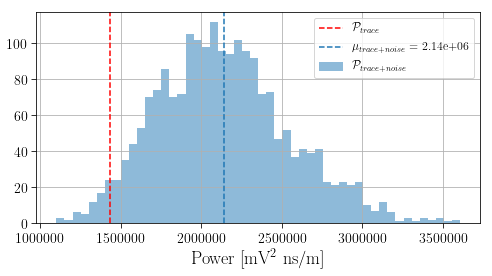

In [16]:
# plt.figure(figsize=(7,4))

# powArr = np.array([calculatePower(wf.times[1], wf.ch10Wf[2]+np.roll(j.ch10Wf,np.random.randint(80))) for j in softWf.itertuples()])
# plt.hist(powArr, bins = 50, alpha = 0.5, label = "$ \mathcal{P}_{trace+noise}$");
# plt.axvline(calculatePower(wf.times[1], wf.ch10Wf[2]), ls="--", color = "red", label = "$\mathcal{P}_{trace}$")
# plt.axvline(powArr.mean(), ls="--", label = "$\mu_{trace+noise}$ = %0.2e"%powArr.mean())
# # plt.axvline(powArr.mean()-2*powArr.std(), ls="-.", color = "green", label = "$\mu-2\sigma = %0.2e$"%(powArr.mean()-2*powArr.std()))
# # plt.title("Ch 10 [Hpol]")
# plt.grid()
# # plt.xscale('log')
# plt.xlabel("Power [mV$^2$ ns/m]")
# plt.legend()
# plt.tight_layout()
# plt.savefig(my_path_plots+'/SpiceCorePolReco/AddNoisetoSpiceExample.png', dpi=250)

In [62]:
2*calculatePower(wf.times[1], wf.ch10Wf[2])-powArr.mean()

713796.725085408

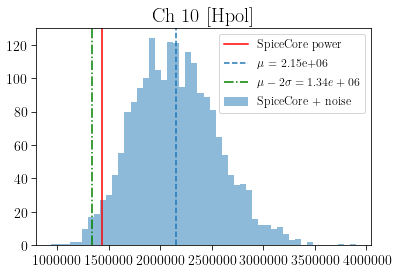

In [59]:
plt.axvline(calculatePower(wf.times[1], wf.ch10Wf[2]), color = "red", label = "SpiceCore power")
powArr = np.array([calculatePower(wf.times[1], wf.ch10Wf[2]-np.roll(j.ch10Wf,np.random.randint(80))) for j in softWf.itertuples()])
plt.hist(powArr, bins = 50, alpha = 0.5, label = "SpiceCore + noise");
plt.axvline(powArr.mean(), ls="--", label = "$\mu$ = %0.2e"%powArr.mean())
plt.axvline(powArr.mean()-2*powArr.std(), ls="-.", color = "green", label = "$\mu-2\sigma = %0.2e$"%(powArr.mean()-2*powArr.std()))
plt.title("Ch 10 [Hpol]")
plt.legend()

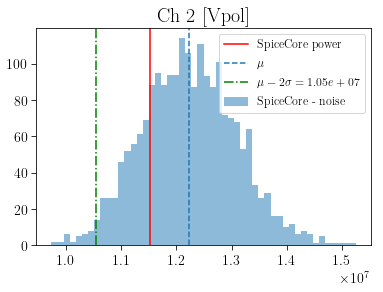

In [51]:
plt.axvline(calculatePower(wf.times[1], wf.ch2Wf[2]), color = "red", label = "SpiceCore power")
powArr = np.array([calculatePower(wf.times[1], wf.ch2Wf[2]+np.roll(j.ch2Wf,np.random.randint(80))) for j in softWf.itertuples()])
plt.hist(powArr, bins = 50, alpha = 0.5, label = "SpiceCore - noise");
plt.axvline(powArr.mean(), ls="--", label = "$\mu$")
plt.axvline(powArr.mean()-2*powArr.std(), ls="-.", color = "green", label = "$\mu-2\sigma = %0.2e$"%(powArr.mean()-2*powArr.std()))
plt.title("Ch 2 [Vpol]")
plt.legend()

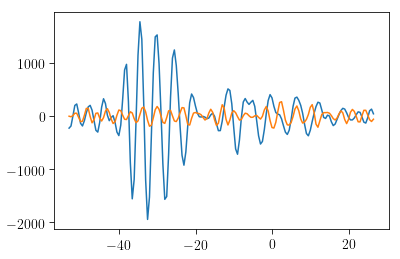

In [81]:
plt.plot(wf.times[1], wf.ch1Wf[2], label = "SpiceCore")
plt.plot(wf.times[1], softWf.ch1Wf[len(wf)-1])

Text(0.5,1,'Ch 10, Hpol')

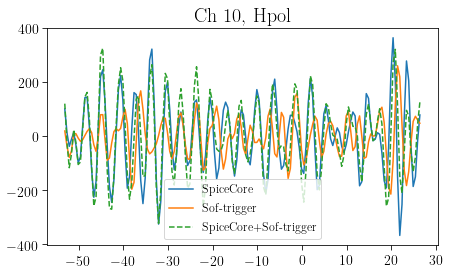

In [10]:
plt.figure(figsize=(7,4))
plt.plot(wf.times[1], wf.ch10Wf[2], label = "SpiceCore")
# plt.plot(wf.times[1], (softWf.ch10Wf[10]), label = "Sof-trigger")
plt.plot(wf.times[1], np.roll(softWf.ch10Wf[10],4), label = "Sof-trigger")

plt.plot(wf.times[1], wf.ch10Wf[2]+np.roll(softWf.ch10Wf[10],4), "--", label = "SpiceCore+Sof-trigger")
plt.legend()
plt.title("Ch 10, Hpol")

In [81]:
rec_ang = estimatePolRayTracer(wf.interp_depth[len(wf)-1])[2]
R = getR(9.63, 0, 213, 0, 0)
omega = getOmega(rec_ang, R)
R

0.2126294137828391

In [46]:
wf.tail()

,evNum,ch0Wf,ch1Wf,ch2Wf,ch3Wf,ch4Wf,ch5Wf,ch6Wf,ch7Wf,ch8Wf,...,ch11Wf,ch12Wf,ch13Wf,ch14Wf,ch15Wf,times,theta_reco,phi_reco,unixTime,interp_depth
1116,19023,"[26.28370921116917, -2.2516269587315882, 2.499...","[0.2303150624303852, 0.2567142225583885, 0.035...","[135.85127436580373, -105.13552527192593, -276...","[0.12139353492273325, 0.06387411708597396, -0....","[-56.94071133388167, -13.705020758601542, 49.2...","[31.944799771956433, 77.13476459093613, 40.969...","[-127.16062005351672, -10.748565106625074, 137...","[-43.171175624855195, 28.305843645488096, 83.6...","[117.53602834407782, 8.8547809437414, -110.603...",...,"[-0.01544758041890502, -0.04204718880388399, -...","[-202.93207481412833, -116.17538302578352, 8.5...","[50.84758069801192, -128.22942747622264, -233....","[-41.79202596527925, -105.92608903126211, -117...","[132.2396778114419, -104.19339515657066, -226....","[-18.10492218330414, -17.60492218330414, -17.1...",100.0,254.0,1545619966,602.592593
1117,19040,"[-15.391409704090945, -86.8267249027108, -92.0...","[-220.63625460192435, -517.3377724113243, -684...","[-21.66581551010037, -50.61300241256832, -27.7...","[0.3531288811548445, 0.2860243848056337, 0.129...","[86.33145555444321, 79.90187358643567, 9.47879...","[-83.33403544968651, -39.987081705733836, 57.9...","[62.6558211866743, -74.4953239813375, -108.819...","[47.29322496798018, 11.893576670654195, -16.34...","[-322.05982795822956, -383.2238005496652, -161...",...,"[-0.2800646861249252, -0.2876447938090228, -0....","[2.996975817071276, -93.09360582702536, -142.4...","[-46.56201765871157, -38.68581507691796, -9.97...","[103.1114595141425, 106.30227367467934, -46.92...","[66.9132052348888, -159.52340652729717, -279.5...","[-21.10492218330414, -20.60492218330414, -20.1...",100.0,254.0,1545619968,602.222222
1118,19043,"[-17.430279070437408, -21.126511474610524, -16...","[455.43396429476036, 815.9813840606025, 786.19...","[-35.41963975184542, -141.89639308441764, -83....","[0.5072422595748731, 0.48579850768124744, 0.33...","[13.221307416914279, -13.609895315327892, -35....","[77.03064840226133, 113.00641747676053, 40.554...","[18.332170851165703, -18.74434211769032, 44.24...","[-83.78875128068837, -48.50750268624897, 82.80...","[-148.27331472883364, -109.25072383715496, 98....",...,"[-0.04663818876741692, -0.0948325047920542, -0...","[128.67049657304568, 268.25221921897156, 266.5...","[250.31375987987172, 221.83425863478357, 68.84...","[345.3342026814096, 219.43065667265682, -61.08...","[603.2946488952466, 72.82553341539196, -454.46...","[-12.530976863202952, -12.030976863202952, -11...",100.0,254.0,1545619969,602.037037
1119,19046,"[38.65169224182916, 69.27141717694275, 48.7176...","[-0.6073445544169878, -0.6640421426384628, -0....","[1092.129986295155, 948.8153530896243, 264.438...","[-0.21197221642116293, -0.016935755899971615, ...","[80.72577582535088, 18.663831040220856, -78.97...","[-73.95048767429816, -38.14506462627948, 26.07...","[25.673373626831083, 99.50024474528242, 94.477...","[436.8954721796963, 738.8076054822396, 564.051...","[122.99262157412089, 177.89405642555755, 149.1...",...,"[-0.1782872084205946, -0.15461484464590558, -0...","[-40.8440198414805, -39.58501802577087, 21.726...","[-0.9438774266224854, -167.78643485306247, -20...","[18.26280677783044, 229.540316604456, 212.9057...","[-41.96352906612388, -74.80689874806274, -84.9...","[10.89507781669586, 11.39507781669586, 11.8950...",79.0,255.0,1545619970,601.851852
1120,19052,"[-29.119904106380794, 6.31287880452785, 44.813...","[-0.04383713969498049, 0.0344841978092541, 0.0...","[64.01349807613238, 544.8929069919864, 849.375...","[-319.29963068791494, -518.7353887520452, -518...","[10.732680750120826, -5.2740956503571015, 20.0...","[-30.21972230947586, -18.346988291751927, 48.9...","[-56.23658951251388, -32.955453269104765, -32....","[-70.63638463577968, -62.893642943235996, -21....","[-236.58009972326815, -124.57204429029343, 8.7...",...,"[-151.4370502303545, -74.3216872635322, 59.911...","[

In [10]:
df = pd.read_pickle("./data/noiseSubtractAmyMethod_run012559_allDepths.pkl")
df = df.loc[(df.depth<1100) & (df.depth>600)]
df.reset_index(drop=True, inplace=True)
wf.reset_index(drop=True, inplace=True)
df["theta_reco"] = wf.theta_reco
df = df.loc[df.theta_reco>=90]


In [11]:
len(df)

719

In [12]:
len(df)

719

In [13]:
747/1028

0.7266536964980544

In [14]:
def getPsi(R):
#     theta = np.radians(theta)
#     phi = np.radians(phi)
#     numerator = np.cos(theta)*np.sin(phi)+R*np.cos(phi)
#     denominator = np.cos(theta)*np.cos(phi)-R*np.sin(phi)
    return np.degrees(np.arctan(R))

def getOmega(theta, R):
    theta = np.radians(theta)
    numerator = np.sin(theta)
    denominator = np.sqrt(1+R**2)
    return np.degrees(np.arccos(numerator/denominator))

def getR(powH, powH_noise, powV, powV_noise, chi):
    Rmeas = np.sqrt((powH-powH_noise)/(powV-powV_noise))
    return np.sqrt((1-chi)*Rmeas**2-chi)

In [15]:
R = getR(df.ch10Pow, 0, df.ch2Pow, 0, 0)
Om = getOmega(df.rec_ang, R)
psi = getPsi(R)

## For all channels

In [16]:
noisePowerChan = np.array([ 198948.83237201,  618793.94802602,  741895.28129648,
        272935.49802384,  324209.48699648,  208490.58954556,
        641412.61161848,  341862.21483048,  986471.80705882,
        608865.14894156,  710127.49137097,  551354.39763633,
        691066.29589686,  360988.99495955,  834482.5863635 ,
       2020906.83550409])

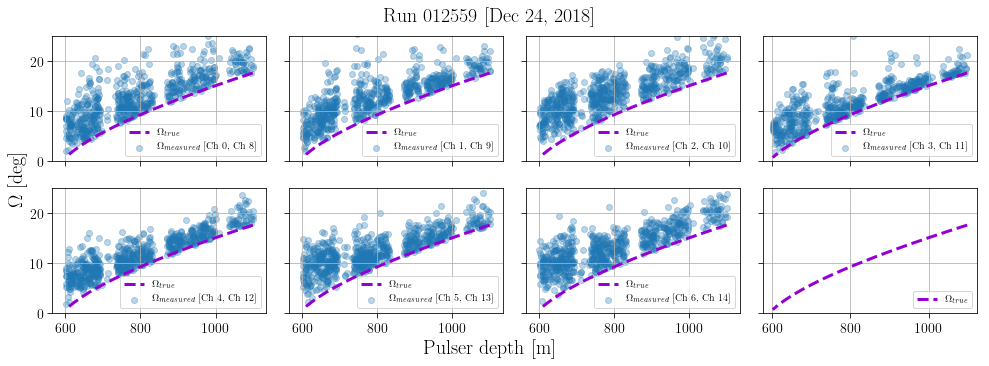

In [17]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:7], df.columns[8:]):
#     print(a,b)
    R = getR(df["%s"%b]/noisePowerChan[ch+8],0,df["%s"%a]/noisePowerChan[ch],0,0.)
    values = getOmega(df.rec_ang, R)
#         errors = unumpy.std_devs(getOmega(avgWf.recAng,getR(avgWf["%s"%b]/noisePowerChan[ch+8],noisePowerChan[ch+8]/noisePowerChan[ch+8],avgWf["%s"%a]/noisePowerChan[ch],noisePowerChan[ch]/noisePowerChan[ch],0)))
    axs[ch].scatter(df.depth, values, alpha = 0.3, label = "$\Omega_{measured}$ [Ch %i, Ch %i]"%(ch,ch+8))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
    ax.set_ylim(0,25)
    ax.set(xlabel="", ylabel = "")
    ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()

    ax.legend(loc="lower right", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, '$\Omega$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCoreScatterAmyMethod_run012559.png', dpi=250)


## Histogram

In [19]:
def find68Perc(x,y):
    for bins in range(len(y)):
        integral = sum(y[:bins])*(x[1]-x[0])
        if(integral>0.68):
            break
    return x[bins]

No handles with labels found to put in legend.


2.8518631532299934
[1.57598164]
2.8848553928115774
[2.0265332]
2.659650837859924
[2.59865314]
2.376342184573777
[0.00327284]
2.094812200407465
[1.19161629]
2.7409335773680468
[1.41345357]
2.731258135154121
[3.15228921]


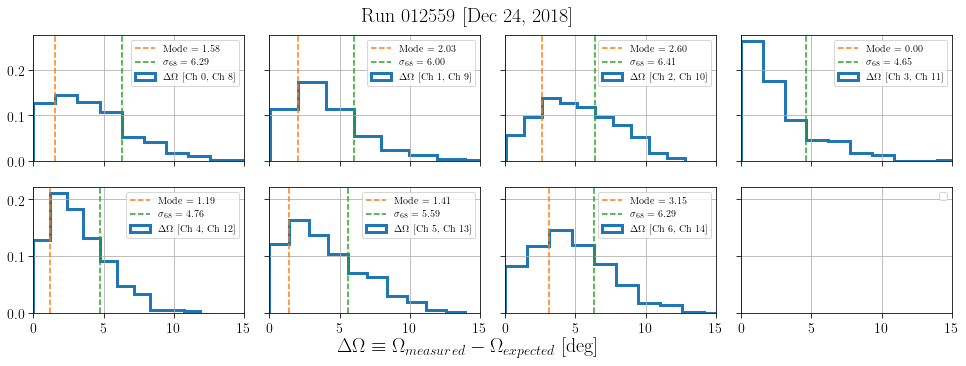

In [125]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:7], df.columns[8:]):
#     print(a,b)
    R = getR(df["%s"%b]/noisePowerChan[ch+8],0,df["%s"%a]/noisePowerChan[ch],0,0.)
    values = getOmega(df.rec_ang, R)
    pol = getOmega(df.rec_ang,0)
    delta = values[~np.isnan(values)]-pol[~np.isnan(values)]
    y, x, _ = axs[ch].hist(delta,label = "$\Delta\Omega$ [Ch %i, Ch %i]"%(ch,ch+8), bins = 10, histtype='step', stacked=True, fill=False, lw = 3, density = True);
    mode = x[np.where(y == y.max())]
    axs[ch].axvline(mode, ls="--", color = "C1", label = "Mode = %0.2f"%mode)
    Interval68Pct = find68Perc(x,y)
    axs[ch].axvline(Interval68Pct, ls="--", color = "C2", label = "$\sigma_{68}$ = %0.2f"%Interval68Pct)

    ch+=1
    print(delta.std())
    print(x[np.where(y == y.max())])
for ax in axs:
    ax.set_xlim(0,15)
#     ax.set_ylim(0,30)
    ax.set(xlabel="", ylabel = "")
    ax.grid()

    ax.legend(loc="upper right", fontsize=10)

fig.text(0.5, 0.03, '$\Delta\Omega \equiv \Omega_{measured}-\Omega_{expected}$ [deg]', ha='center', va='center', fontsize=20) 
# fig.text(0.03, 0.5, '$\Omega$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaOmega_Amymethod_run012559.png', dpi=250)


# psi

No handles with labels found to put in legend.


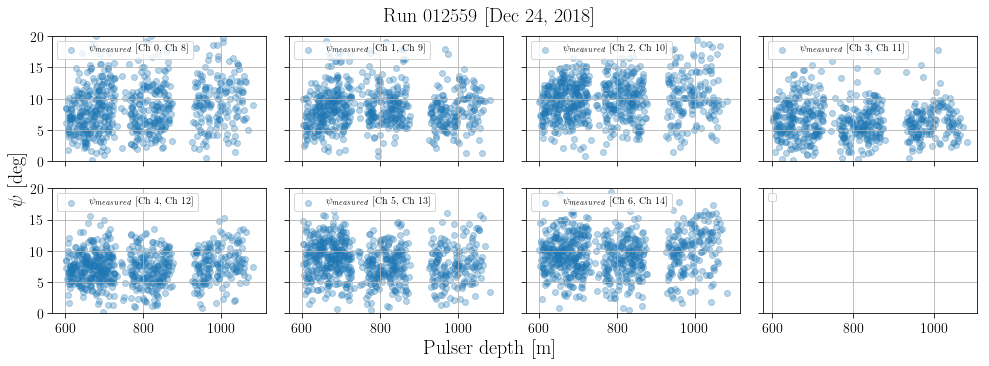

In [126]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:7], df.columns[8:]):
#     print(a,b)
    R = getR(df["%s"%b]/noisePowerChan[ch+8],0,df["%s"%a]/noisePowerChan[ch],0,0.)
    values = getPsi(R)
#         errors = unumpy.std_devs(getOmega(avgWf.recAng,getR(avgWf["%s"%b]/noisePowerChan[ch+8],noisePowerChan[ch+8]/noisePowerChan[ch+8],avgWf["%s"%a]/noisePowerChan[ch],noisePowerChan[ch]/noisePowerChan[ch],0)))
    axs[ch].scatter(df.depth, values, alpha = 0.3, label = "$\psi_{measured}$ [Ch %i, Ch %i]"%(ch,ch+8))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
    ax.set_ylim(0,20)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, '$\psi$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCoreScatterAmyMethod_run012559.png', dpi=250)


No handles with labels found to put in legend.


3.8112521081648985
[6.31056694]
3.699358820993639
[6.95696385]
3.2496919513432885
[9.87884616]
3.1484863297253867
[4.76205947]
2.71366013439066
[6.7574986]
3.0961775679145163
[7.24473872]
3.153866283989729
[8.39158787]


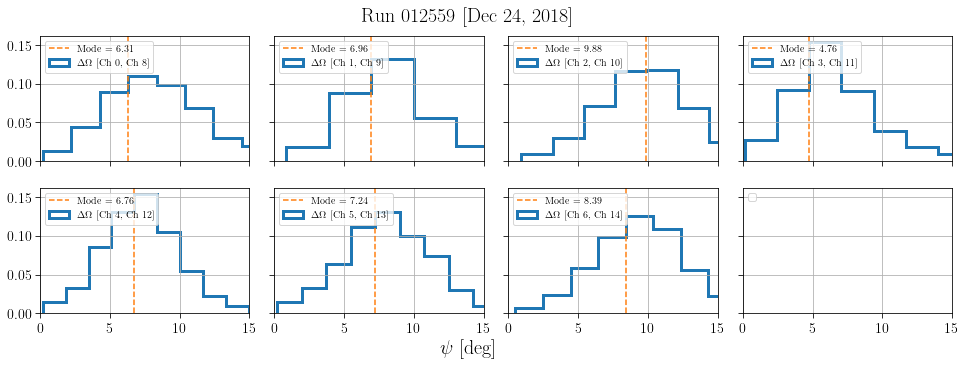

In [20]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:7], df.columns[8:]):
#     print(a,b)
    R = getR(df["%s"%b]/noisePowerChan[ch+8],0,df["%s"%a]/noisePowerChan[ch],0,0.)
    values = getPsi(R)
    pol = 0
    delta = values[~np.isnan(values)]-0
    y, x, _ = axs[ch].hist(delta,label = "$\Delta\Omega$ [Ch %i, Ch %i]"%(ch,ch+8), bins = 10, histtype='step', stacked=True, fill=False, lw = 3, density = True);
    mode = x[np.where(y == y.max())]
    axs[ch].axvline(mode, ls="--", color = "C1", label = "Mode = %0.2f"%mode)
    Interval68Pct = find68Perc(x,y)
#     axs[ch].axvline(Interval68Pct, ls="--", color = "C2", label = "$\sigma_{68}$ = %0.2f"%Interval68Pct)

    ch+=1
    print(delta.std())
    print(x[np.where(y == y.max())])
for ax in axs:
    ax.set_xlim(0,15)
#     ax.set_ylim(0,30)
    ax.set(xlabel="", ylabel = "")
    ax.grid()

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, '$\psi$ [deg]', ha='center', va='center', fontsize=20) 
# fig.text(0.03, 0.5, '$\Omega$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/psi_Amymethod_run012559.png', dpi=250)


No handles with labels found to put in legend.


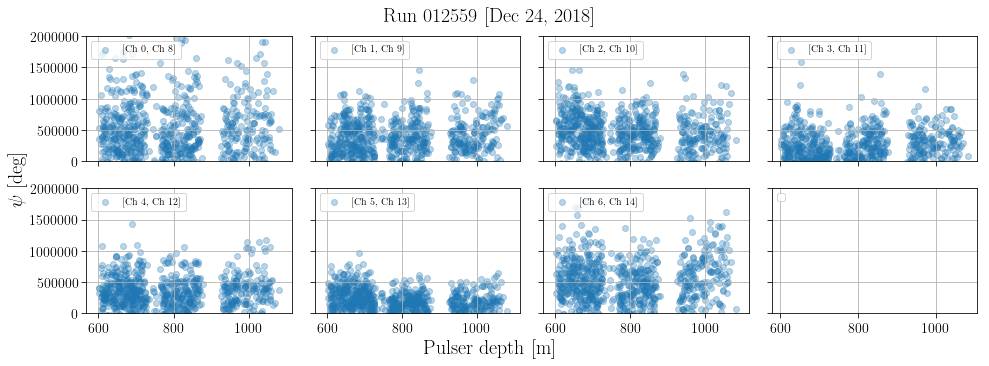

In [129]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[8:15], df.columns[8:]):
    axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "[Ch %i, Ch %i]"%(ch,ch+8))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
    ax.set_ylim(0,2E6)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
#     ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, '$\psi$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCoreScatterAmyMethod_run012559.png', dpi=250)


In [104]:
df.ch1Pow

92      1.416304e+07
93      1.107657e+07
94      1.216923e+07
95      1.703279e+07
96      2.388895e+06
            ...     
1115    1.455532e+07
1116    1.931751e+07
1117    2.651738e+07
1118    2.175549e+07
1119    2.235952e+07
Name: ch1Pow, Length: 1028, dtype: float64

In [105]:
ch = 0
chs = []
frac = []
for a,b in zip(df.columns[:16], df.columns[:16]):
    sub = df["%s"%a]
    frac.append(len(sub[sub<0])/len(sub))
    chs.append(ch)
    ch+=1

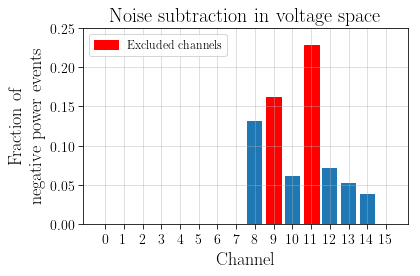

In [106]:
import matplotlib.patches as mpatches

plt.figure(figsize=(6,4))
barlist = plt.bar(chs,frac)
barlist[9].set_color('r')
barlist[11].set_color('r')
barlist[15].set_color('r')

plt.xticks(np.arange(0, 16, step=1));
plt.grid(alpha = 0.5)
plt.xlabel("Channel")
plt.ylabel("Fraction of \n negative power events")
plt.title("Noise subtraction in voltage space")
plt.ylim(0,0.25)


red_patch = mpatches.Patch(color='red', label='Excluded channels')
plt.legend(handles=[red_patch])
plt.tight_layout()


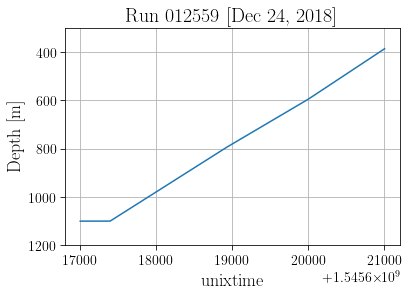

In [16]:
plt.plot(wf.unixTime,wf.interp_depth)
plt.ylim(1200,300)
plt.title("Run 012559 [Dec 24, 2018]")
plt.xlabel("unixtime")
plt.ylabel("Depth [m]")
plt.grid()

In [44]:
R = getR(df.ch8Pow/noisePowerChan[8],0,df.ch0Pow/noisePowerChan[0],0,0.03)

In [45]:
len(R.dropna())

196

In [46]:
196/619

0.3166397415185784